In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# --- 1. Setup and Data Loading ---
# Set device to MPS if available, otherwise CPU
import torch

# Correctly check for CUDA, then MPS, and fall back to CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")
# Define transformations for the data
# ToTensor() converts images to PyTorch Tensors and scales them to [0, 1]
# Normalize() adjusts tensor values to have a mean of 0.5 and std of 0.5 for each channel
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download and load the training data
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                          shuffle=True)

# Download and load the test data
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                         shuffle=False)

print(len(train_dataset), len(test_dataset))

# Define the class names
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Using device: mps
50000 10000


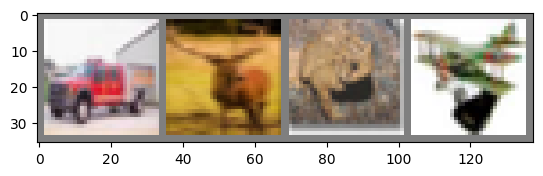

truck deer  frog  airplane


In [13]:
# --- 2. Visualize Data ---
# Function to show an image
def imshow(img):
    # Un-normalize the image
    img = img / 2 + 0.5
    npimg = img.numpy()
    # Matplotlib expects (H, W, C) but PyTorch tensors are (C, H, W)
    # We use np.transpose to rearrange the dimensions
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show first 4 images from the batch and their labels
imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


In [14]:
# --- 3. Define the CNN Model ---
# Keras Sequential is similar to nn.Sequential, but defining a class gives more flexibility.
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # This is the CNN part, equivalent to your first block of layers
        self.conv_layers = nn.Sequential(
            # Input: 3 channels (RGB), Output: 32 channels
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Input: 32 channels, Output: 64 channels
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Input: 64 channels, Output: 128 channels
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # This is the ANN (classifier) part, equivalent to your Dense layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # The input features must be calculated based on the output of the conv layers
            # For a 32x32 image, it becomes 2x2x128 after the conv/pool layers
            nn.Linear(128 * 2 * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 10)
            # Softmax is not needed here because nn.CrossEntropyLoss applies it internally
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

# Instantiate the model and move it to the configured device
cnn = ConvNet().to(device)
print(cnn)

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [15]:
# --- 4. Define Loss Function and Optimizer ---
# Corresponds to loss = 'sparse_categorical_crossentropy'
criterion = nn.CrossEntropyLoss()
# Corresponds to optimizer = 'adam'
optimizer = optim.Adam(cnn.parameters(), lr=0.001)


In [16]:
# --- 5. Train the Model ---
# This is the equivalent of cnn.fit()
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # Move inputs and labels to the device (GPU/CPU)
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = cnn(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update weights

        running_loss += loss.item()
        if (i + 1) % 200 == 0:  # Print progress every 200 mini-batches
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print('Finished Training')


Epoch [1/10], Step [200/782], Loss: 1.8005
Epoch [1/10], Step [400/782], Loss: 1.2977
Epoch [1/10], Step [600/782], Loss: 1.3520
Epoch [2/10], Step [200/782], Loss: 1.1389
Epoch [2/10], Step [400/782], Loss: 1.0659
Epoch [2/10], Step [600/782], Loss: 1.0687
Epoch [3/10], Step [200/782], Loss: 1.1343
Epoch [3/10], Step [400/782], Loss: 0.7328
Epoch [3/10], Step [600/782], Loss: 0.9389
Epoch [4/10], Step [200/782], Loss: 1.1980
Epoch [4/10], Step [400/782], Loss: 0.7651
Epoch [4/10], Step [600/782], Loss: 0.9991
Epoch [5/10], Step [200/782], Loss: 0.8644
Epoch [5/10], Step [400/782], Loss: 1.0336
Epoch [5/10], Step [600/782], Loss: 0.6751
Epoch [6/10], Step [200/782], Loss: 0.6483
Epoch [6/10], Step [400/782], Loss: 0.9013
Epoch [6/10], Step [600/782], Loss: 0.8560
Epoch [7/10], Step [200/782], Loss: 0.5055
Epoch [7/10], Step [400/782], Loss: 0.6438
Epoch [7/10], Step [600/782], Loss: 0.6552
Epoch [8/10], Step [200/782], Loss: 0.5013
Epoch [8/10], Step [400/782], Loss: 0.4120
Epoch [8/10

In [17]:
# --- 6. Evaluate the Model ---
# This is the equivalent of cnn.evaluate()
cnn.eval()  # Set the model to evaluation mode (disables dropout)
with torch.no_grad(): # No need to calculate gradients during evaluation
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn(images)

        # torch.max returns (value, index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc:.2f} %')

Accuracy of the network on the 10000 test images: 73.94 %


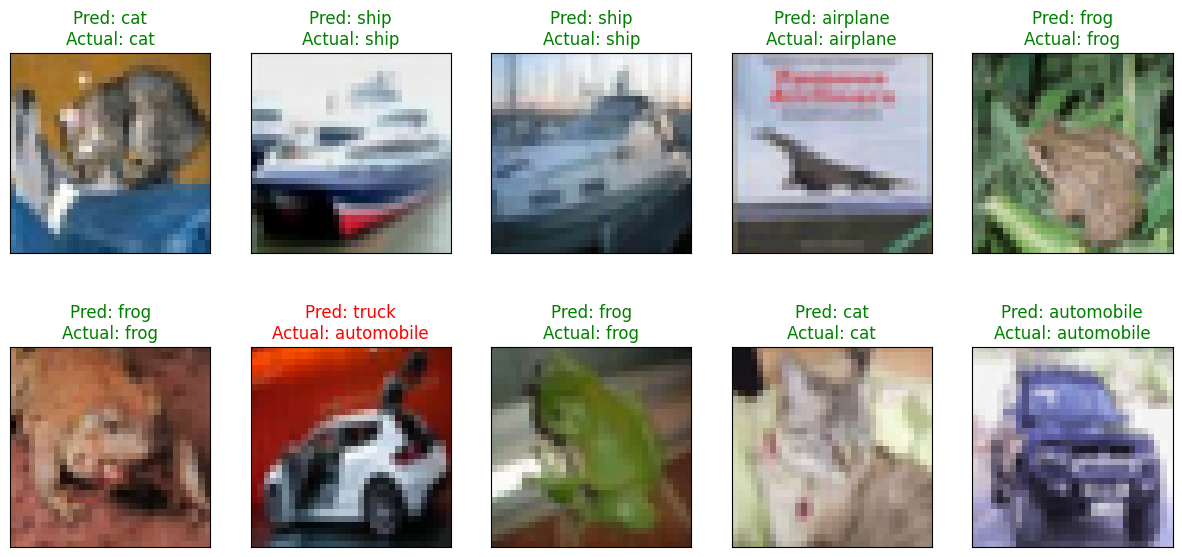

In [18]:
# --- 7. Make Predictions and Visualize ---
# This is the equivalent of cnn.predict() and the final visualization loop
cnn.eval()
with torch.no_grad():
    # Get a batch of test data
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Move to device and get predictions
    images_on_device = images.to(device)
    outputs = cnn(images_on_device)
    _, predicted = torch.max(outputs, 1)

    # Show the first 10 images, their predicted labels, and the actual labels
    fig = plt.figure(figsize=(15, 7))
    for i in range(10):
        ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        img = images[i] / 2 + 0.5  # Un-normalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

        pred_class = classes[predicted[i].item()]
        actual_class = classes[labels[i].item()]
        color = "green" if pred_class == actual_class else "red"
        ax.set_title(f'Pred: {pred_class}\nActual: {actual_class}', color=color)
    plt.show()







